# Defining ODE layers in Jax

In [1]:
!pip install jax jaxlib flax

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Toy dataset

Based on the definitions in https://arxiv.org/pdf/1505.05770.pdf.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax
from typing import Any, Callable, Sequence, Optional
from jax import lax,random,numpy as jnp
import flax
from flax import linen as nn

def w1(z1,z2): return jnp.sin(2*jnp.pi*z1/4.)
def w2(z1,z2): return 3*jnp.exp(-.5*(z1-1)**2/.36)
def w3(z1,z2): return 3*jax.nn.sigmoid((z1-1)/.3)

def U1(z1,z2): return .5*((jnp.linalg.norm(jnp.stack((z1,z2), axis=-1), axis=-1)-2)/.4)**2 - jnp.log(jnp.exp(-.5*((z1-2/.6))**2) + jnp.exp(-.5*((z1+2/.6))**2))
def U2(z1,z2): return .5*((z2-w1(z1,z2))/.4)**2
def U3(z1,z2): return -jnp.log(jnp.exp(-.5*((z2-w1(z1,z2))/.4)**2) + jnp.exp(-.5*((z2-w1(z1,z2)+w2(z1,z2))/.35)**2))
def U4(z1,z2): return -jnp.log(jnp.exp(-.5*((z2-w1(z1,z2))/.4)**2) + jnp.exp(-.5*((z2-w1(z1,z2)+w3(z1,z2))/.35)**2))
Us = (U1,U2,U3,U4)

def f(U,z1,z2): return jnp.exp(-U(z1,z2))

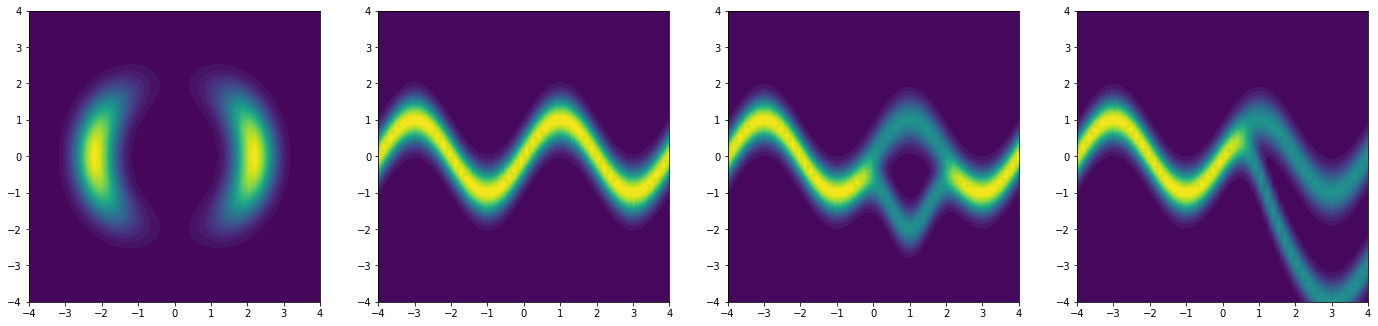

In [3]:
xs = ys = jnp.linspace(-4,4)

fig,axs = plt.subplots(ncols=len(Us), figsize=(24,6))
xgrid,ygrid = jnp.meshgrid(xs,ys)

for ax,U in zip(axs,Us):
    ax.set_aspect('equal')
    zs = jnp.exp(-U(xgrid,ygrid))
    plot = ax.contourf(xgrid,ygrid,zs,30)

## Continuous normalizing flow

$$ \frac{d\mathbf{z}(t)}{dt} = \sum_{n=1}^M f_n(\mathbf{z}(t)), \frac{d\log p(\mathbf{z}(t))}{dt} = \sum_{n=1}^M \mathrm{tr} \left( \frac{\partial}{\partial f_n \mathbf{z}} \right) $$

The paper https://arxiv.org/pdf/1806.07366.pdf uses $M=64$.

Currently reading https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py to determine CNF architecture and hyperparameter settings.

That repo implements the CNF by first defining a `hypernet: t->W` which outputs a set of weights. In Jax we'll have `hypernet: (t,H)->W`. The CNF is then defined as `f: (t,H,z)-> dz/dt, dlogp_z/dt`

In [4]:
from flax.core import freeze,unfreeze

class HyperNetwork(nn.Module):
    in_out_dim: int
    hidden_dim: int
    width: int
        
    @property
    def blocksize(self): return self.width*self.in_out_dim
    
    @nn.compact
    def __call__(self, inputs):
        # predict params
        x = inputs
        features = [self.hidden_dim, self.hidden_dim, 3*self.blocksize + self.width]
        for i,feat in enumerate(features):
            x = nn.Dense(feat)(x)
            if i!= 2:
                x = nn.tanh(x)
                
        # restructure
        x = x.reshape(-1)
        W = x[:self.blocksize].reshape(self.width, self.in_out_dim, 1) 
        
        U = x[self.blocksize:2*self.blocksize].reshape(self.width, 1, self.in_out_dim) 
        G = x[2*self.blocksize:3*self.blocksize].reshape(self.width, 1, self.in_out_dim) 
        U = U * nn.sigmoid(G)
        
        B = x[3*self.blocksize:].reshape(self.width, 1, 1)
        
        return [W,B,U]
    
key1,key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (1,1))

hidden_dim = 32
width = 64

hyper_net = HyperNetwork(2, hidden_dim, width)
params = hyper_net.init(key2,x)
y = hyper_net.apply(params, x)
print('initialised parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', [f'{t.shape}' for t in y])

initialised parameter shapes:
 {'params': {'Dense_0': {'bias': (32,), 'kernel': (1, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (448,), 'kernel': (32, 448)}}}
output:
 ['(64, 2, 1)', '(64, 1, 1)', '(64, 1, 2)']


In [97]:
# class CNF(nn.Module):
#     in_out_dim: int
#     hidden_dim: int
#     width: int
    
#     @nn.compact
#     def __call__(self, inputs, t):
#         z = inputs[0]
#         logp_z = inputs[1]
        
#         W,B,U = HyperNetwork(self.in_out_dim,self.hidden_dim,self.width)(t)
        
#         z_blocks = compute_zblocks(W,B,U,t,z)
#         z_blocks_grad = jax.hessian(compute_zblocks,-1)(W,B,U,t,z)
        
#         dz_dt = z_blocks.mean(0)
#         d_log_p_dt = -jnp.einsum('mijj->mi',z_blocks_grad).mean(0)
        
#         return (dz_dt,d_log_p_dt)

class CNF(nn.Module):
    in_out_dim: int
    hidden_dim: int
    width: int
    
    def setup(self):
        self.hyper_net = HyperNetwork(self.in_out_dim,self.hidden_dim,self.width)
    
    def __call__(self, inputs, *t):
        print(inputs)
        print(t)
        z = inputs[0]
        logp_z = inputs[1]
        
        W,B,U = self.hyper_net(t)
        
        z_blocks = compute_zblocks(W,B,U,t,z)
        z_blocks_grad = jax.hessian(compute_zblocks,-1)(W,B,U,t,z)
        
        dz_dt = z_blocks.mean(0)
        d_log_p_dt = -jnp.einsum('mijj->mi',z_blocks_grad).mean(0)
        
        return (dz_dt,d_log_p_dt)
    
def compute_zblocks(W,B,U,t,z):
    Z = jnp.expand_dims(z, 0)
    h = nn.tanh(Z@W + B)
    z_blocks = (h@U).squeeze(1)
    return z_blocks
    
key1,key2 = random.split(random.PRNGKey(0), 2)

in_out_dim = 2
hidden_dim = 32
width = 64

z,p_z = jnp.split(random.uniform(key1, (2*in_out_dim,)),2)
t = jnp.array([0.])

cnf = CNF(in_out_dim, hidden_dim, width)
params = cnf.init(key2,(z,p_z),t)
y = cnf.apply(params,(z,p_z),t)
print('initialised parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', [f'{t.shape}' for t in y])

(DeviceArray([0.5552479, 0.9147607], dtype=float32), DeviceArray([0.29765356, 0.508113  ], dtype=float32))
(DeviceArray([0.], dtype=float32),)
(DeviceArray([0.5552479, 0.9147607], dtype=float32), DeviceArray([0.29765356, 0.508113  ], dtype=float32))
(DeviceArray([0.], dtype=float32),)
initialised parameter shapes:
 {'params': {'hyper_net': {'Dense_0': {'bias': (32,), 'kernel': (1, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (448,), 'kernel': (32, 448)}}}}
output:
 ['(2,)', '(2,)']


In [99]:
from jax.experimental.ode import odeint
from functools import partial

def full_cnf(params,inputs):
    start_and_end_times = jnp.array([0.,1.])
    cnf = CNF(in_out_dim, hidden_dim, width)
    cnf_func = partial(cnf.apply,params) 
    init_state, final_state = odeint(cnf_func, inputs, start_and_end_times, atol=1e-3, rtol=1e-3)
    return final_state

full_cnf(params,(z,p_z))

# batched_cnf = jax.vmap(full_cnf, in_axes=(None,0))

def cnf_loss(params, inputs):
    preds = batched_cnf(params, inputs)
    return preds

# cnf_loss(params, x)

(Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>)
(Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>,)


In [100]:
jax.grad(full_cnf)

<function __main__.full_cnf(params, inputs)>

In [ ]:
n_iters = 10

for i in range(n_iters):
    